# DTI 


### Import Library

In [2]:
import pydicom
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from skimage.io import imread
import seaborn as sns
from glob import glob
import ipywidgets as widgets
import scipy.ndimage as ndimage
import imageio
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go
import math
import openpyxl


### Define the Mosaic dicom picture fiel and path in .ima format 

In [3]:
##  Mosaic Picturess  ####

mosaic_pictures_files = "/Applications/tez/tez_data_dti_deneme/TOMRUK_ZAHIDE_DTI/DTI/DIFFUSION_HIGHRES_0009/" # Our input 
mosaic_paths = os.listdir(mosaic_pictures_files)
mosaic_paths.sort() # Bu sort işlemi aslında çok öneli çünkü biz bu kodu her çalıştırdığımızda aynı sıralamayı veriyor ve bize bir nevi referans oluyor.
nSeries = len(mosaic_paths)
nSeries

71

In [4]:
GTmp = np.zeros((nSeries, 3))

### Slices Information

In [5]:
mosaic_picture = pydicom.read_file(mosaic_pictures_files + mosaic_paths[10])
a = mosaic_picture.fix_meta_info


In [108]:

def shape_calculation_slice(mosaic_picture):
    
    mHeight = mosaic_picture.Rows
    mHeight = int(mHeight)
    mWidth = mosaic_picture.Columns
    mWidth = int(mWidth)


    slice_number = mosaic_picture[0x019, 0x100a]
    slice_number = str(slice_number)
    index = slice_number.find(":")
    slice_number = slice_number[index+2:]
    slice_number = int(slice_number)

    height = int(mHeight / math.sqrt(slice_number))
    width =int(mWidth / math.sqrt(slice_number))

    return slice_number, height, width



In [109]:
slice_number, height, width = shape_calculation_slice(mosaic_picture)


slice_number, height, width

(64, 128, 128)

### Spliting Mosaic pictures

In [8]:
def split_slice(path):
    """
    Split the only one mosaic pictures
    """
    liste = []
    
    mosaic_picture = pydicom.read_file(path)
    b_val = mosaic_picture[0x019, 0x100c] # B değerini veriyor ama sayısal veri vermiyor 
    str_b_value = str(b_val)
    index = str_b_value.find("'")
    selected = str_b_value[index+1:len(str_b_value)-1]
    b_values = int(selected)
    mosaic_ndarray = mosaic_picture.pixel_array
    
    for i in range(8):
        for j in range(8):
            slice = mosaic_ndarray[i*128:(i*128)+128,j*128:(j*128)+128]
            liste.append(slice)
            
    return  liste, b_values




In [9]:
mosaic_slices, b_val = split_slice(mosaic_pictures_files + mosaic_paths[12])

In [10]:
b_val

700

In [11]:

def all_mosaic_split(mosaic_pictures_files):
    """
    Split the all mosaic slices in given files
    """ 

    mosaic_paths = os.listdir(mosaic_pictures_files)
    mosaic_paths.sort()

    all_mosaic_slices = []
    b_values = []

    for k in mosaic_paths:
        mosaic_slices, b_val = split_slice(mosaic_pictures_files + k)
        
        mosaic_slices = np.array(mosaic_slices)
        all_mosaic_slices.append(mosaic_slices)
        b_values.append(b_val)
    
    b_values = np.array(b_values)
    all_mosaic_slices = np.array(all_mosaic_slices)

    return all_mosaic_slices, b_values


In [38]:
all_mosaic_slices, b_values = all_mosaic_split(mosaic_pictures_files)

In [39]:
all_mosaic_slices.shape

(71, 64, 128, 128)

In [40]:
b_values

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 700, 700, 700,
       700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700,
       700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700,
       700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700,
       700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700,
       700, 700, 700, 700, 700,   0])

In [41]:
b_values.shape

(71,)

In [18]:
def diffusion_gradient_direction(mosaic_pictures_files):
    """
    Get the diffusion_gradient_direction from image info
    """ 

    xyz_list = []
    x = []
    y = []
    z = []

    mosaic_paths = os.listdir(mosaic_pictures_files)
    mosaic_paths.sort()


    for path in mosaic_paths:

        mosaic_picture = pydicom.read_file(mosaic_pictures_files + path)
        b_val = mosaic_picture[0x019, 0x100c] # B değerini veriyor ama sayısal veri vermiyor  
        str_b_value = str(b_val)
        index = str_b_value.find("'")
        values_int = int(str_b_value[index+1:len(str_b_value)-1])

        if values_int == 0:
            x.append(np.nan)
            y.append(np.nan)
            z.append(np.nan)
            xyz_list.append(np.nan)

        elif values_int > 0:
            dgd = mosaic_picture[0x019, 0x100e]
            dgd_str = str(dgd)
            index=dgd_str.find("FD:")
            index_1 = dgd_str.find("[", index)
            index_2 = dgd_str.find(",", index_1)
            index_3 = dgd_str.find(",", index_2+1)
            index_4 = dgd_str.find("]", index_3)

            x_value = np.array(float(dgd_str[index_1+1:index_2]))
            y_value = np.array(float(dgd_str[index_2+1:index_3]))
            z_value = np.array(float(dgd_str[index_3+1:index_4]))

            x.append(x_value)
            y.append(y_value)
            z.append(z_value)

        else:
            print("Wrong diffusion_gradient_direction information, Should control your code")
            break

        
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    
    return (x,y,z) 

In [19]:
x,y,z = diffusion_gradient_direction(mosaic_pictures_files)


### Burda Zahide Tomruk için kendimiz elle b0 değerlerini ayırdık çünkü elde ettiğimiz b0 verileri liste içinde elde edebildik bilgisiyarda bunu ayıramadık

### B0 ve DWI ların  ayrılması


In [20]:
def b_values_divider(all_mosaic_slices, b_values):

    b0_index = []
    b0_mosaic_slicess = []
    b0_mosaic_slicess = np.array(b0_mosaic_slicess)

    dwi_index = []
    dwi_mosaic_slicess = []
    dwi_mosaic_slicess = np.array(dwi_mosaic_slicess)

    num = 0

    for i in b_values:

        if i == 0:
            b0_index.append(num)
        elif i > 0:
            dwi_index.append(num)
        else:
            print("Hatalı Değer B_values negatif bir değer alamaz")
            
        
        num = num + 1
    
    b0_index = np.array(b0_index)
    dwi_index = np.array(dwi_index)

    b0_mosaic_slicess = all_mosaic_slices[b0_index]
    dwi_mosaic_slicess = all_mosaic_slices[dwi_index]

    return b0_mosaic_slicess, dwi_mosaic_slicess, (b0_index,dwi_index)

In [21]:
b0_mosaic_slicess, dwi_mosaic_slicess, (b0_index,dwi_index) = b_values_divider(all_mosaic_slices, b_values)

In [22]:
b0_mosaic_slicess, dwi_mosaic_slicess, index = b_values_divider(all_mosaic_slices, b_values)

In [23]:
b0_mosaic_slicess.shape

(11, 64, 128, 128)

In [30]:
dwi_mosaic_slicess.shape

(60, 64, 128, 128)

#### Index
Burdaki index verilerimiz bizim sırasıyla aldığımız path den dicom infolarına göre b değerlerinin hangi indexlerde 0 hangilerinde difüzyon olduğunu beliritiyor.

In [24]:
index

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 70]),
 array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
        27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
        44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
        61, 62, 63, 64, 65, 66, 67, 68, 69]))

### B0 değerlerinin ortalamasını alma

In [25]:
def b0_avarager(b0_slicess):
    # all b=0 values mosaic picturees average 
    # 4 dimentional data take average from [11,64,128,128] to [1,64,128,128]
    
    average_slices = [] 

    for i in range(len(b0_slicess[1])):
        img = np.zeros((128,128))
        
        for k in range(len(b0_slicess)):
            b0_img = b0_slicess[k,i,:,:]
            img = b0_img + img

        img = img / len(b0_slicess) 
        average_slices.append(img)


    average_slices = np.array(average_slices)

    return average_slices

In [26]:
b0_average_mosaic_slice = b0_avarager(b0_mosaic_slicess)

In [27]:
b0_average_mosaic_slice.shape

(64, 128, 128)

In [28]:
m0,m1,m2 = b0_average_mosaic_slice.shape
# Add a slider that starts with 0 and ends at the number of
# slices along the axial plane, n0=99.
@widgets.interact(axial_slice=(0,m0-1))
# Define the function that shows the images of the specified slice number.
# It starts with the 10th slice. And you can scroll over any slice
# using the slider.

def axial_slicer(axial_slice=50):
  
  # Show the image of the specified slice number in 'gray' color-map
  # and axial aspect ratio
  
  plt.imshow(b0_average_mosaic_slice[axial_slice,:,:])
  #plt.imshow(mosaic_pictures_vol[axial_slice,:,:], cmap='hot')
  #plt.imshow(mosaic_pictures_vol[axial_slice,:,:], cmap='RdBu')


  # Don't show the axis
  plt.axis('off')
  plt.title("Average b=0 Brain Slices")

interactive(children=(IntSlider(value=50, description='axial_slice', max=63), Output()), _dom_classes=('widget…

### 

In [29]:
data_mosaic = {"Mosaic_Paths":mosaic_paths, "Mosaic_slices": list(all_mosaic_slices), "B_values":b_values, "Gradient_Infromation_X":x, "Gradient_Infromation_Y":y , "Gradient_Infromation_Z":z}
information_mosaic_dataFrame = pd.DataFrame(data_mosaic)
information_mosaic_dataFrame

,Mosaic_Paths,Mosaic_slices,B_values,Gradient_Infromation_X,Gradient_Infromation_Y,Gradient_Infromation_Z
0,TOMRUK_ZAHIDE.MR.HD_MYELIN.0009.0001.2023.05.2...,"[[[0, 1, 5, 3, 2, 2, 2, 3, 6, 2, 1, 7, 4, 2, 4...",0,NaN,NaN,NaN
1,TOMRUK_ZAHIDE.MR.HD_MYELIN.0009.0002.2023.05.2...,"[[[0, 0, 4, 3, 0, 2, 0, 1, 0, 0, 1, 3, 5, 5, 2...",0,NaN,NaN,NaN
2,TOMRUK_ZAHIDE.MR.HD_MYELIN.0009.0003.2023.05.2...,"[[[0, 4, 1, 2, 0, 4, 3, 5, 3, 1, 2, 0, 1, 1, 3...",0,NaN,NaN,NaN
3,TOMRUK_ZAHIDE.MR.HD_MYELIN.0009.0004.2023.05.2...,"[[[0, 4, 2, 2, 3, 5, 2, 2, 5, 1, 2, 3, 2, 1, 3...",0,NaN,NaN,NaN
4,TOMRUK_ZAHIDE.MR.HD_MYELIN.0009.0005.2023.05.2...,"[[[0, 2, 4, 1, 0, 4, 2, 0, 2, 5, 3, 2, 4, 5, 0...",0,NaN,NaN,NaN
...,...,...,...,...,...,...
66,TOMRUK_ZAHIDE.MR.HD_MYELIN.0009.0067.2023.05.2...,"[[[0, 4, 1, 1, 6, 5, 2, 3, 2, 2, 3, 6, 5, 3, 3...",700,0.734374,0.616424,0.284108
67,TOMRUK_ZAHIDE.MR.HD_MYELIN.0009.0068.2023.05.2...,"[[[0, 6, 6, 1, 3, 2, 2, 2, 2, 3, 1, 1, 7, 0, 3...",700,-0.986654,0.151999,0.058401
68,TOMRUK_ZAHIDE.MR.HD_MYELIN.0009.0069.2023.05.2...,"[[[0, 1, 1, 1, 1, 4, 2, 2, 3, 10, 4, 0, 2, 1, ...",700,0.527112,-0.811320,-0.252811
69,TOMRUK_ZAHIDE.MR.HD_MYELIN.0009.0070.2023.05.2...,"[[[0, 5, 2, 5, 1, 6, 5, 1, 2, 3, 3, 3, 4, 1, 4...",700,0.663161,-0.479499,-0.574716


In [31]:
information_mosaic_dataFrame.to_excel('/Applications/tez/kodlarım/python_code/DTI/Tomruk_zahide_Mosaci_data_info.xlsx')

In [32]:
information_mosaic_dataFrame["Mosaic_Paths"]

0     TOMRUK_ZAHIDE.MR.HD_MYELIN.0009.0001.2023.05.2...
1     TOMRUK_ZAHIDE.MR.HD_MYELIN.0009.0002.2023.05.2...
2     TOMRUK_ZAHIDE.MR.HD_MYELIN.0009.0003.2023.05.2...
3     TOMRUK_ZAHIDE.MR.HD_MYELIN.0009.0004.2023.05.2...
4     TOMRUK_ZAHIDE.MR.HD_MYELIN.0009.0005.2023.05.2...
                            ...                        
66    TOMRUK_ZAHIDE.MR.HD_MYELIN.0009.0067.2023.05.2...
67    TOMRUK_ZAHIDE.MR.HD_MYELIN.0009.0068.2023.05.2...
68    TOMRUK_ZAHIDE.MR.HD_MYELIN.0009.0069.2023.05.2...
69    TOMRUK_ZAHIDE.MR.HD_MYELIN.0009.0070.2023.05.2...
70                  Tomruk.DIFFUSION_HighRes.09.001.IMA
Name: Mosaic_Paths, Length: 71, dtype: object

In [53]:
x_gradiants = information_mosaic_dataFrame["Gradient_Infromation_X"][23]
type(x_gradiants)

numpy.float64

In [34]:
img1 = all_mosaic_slices[1]
img1.shape

(64, 128, 128)

In [102]:
vol_image, b_value = split_slice(mosaic_pictures_files+information_mosaic_dataFrame["Mosaic_Paths"][70])
vol_image = np.array(vol_image)
vol_image.shape

(64, 128, 128)

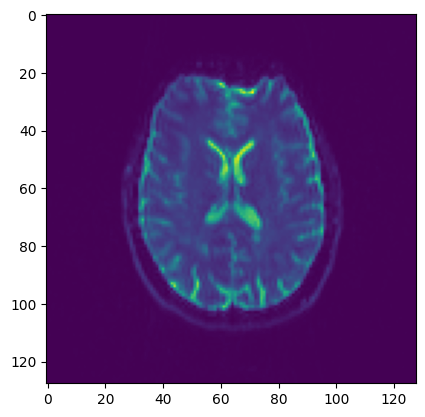

In [103]:
plt.imshow(vol_image[34])

In [45]:
b_value

0

### TRACE  Weighted image calculation
traceIMG = single(nthroot(prod(double(tdtIMG), 3), nDir));
    traceIMG(isinf(traceIMG)) = 0;
    clear tdtIMG;

In [ ]:
t_dwi = dwi_mosaic_slicess.copy()
t_dwi.shape

(60, 64, 128, 128)

In [ ]:
t_dwi_new = t_dwi[1] * t_dwi[0]

In [ ]:
t_dwi_new.shape

(64, 128, 128)

ilk önce (60, 64, 128, 128) datamızı ilk arraye göre çarpacağız
sonra (1, 64, 128, 128) boytulu data elde edeceğiz.

In [95]:
dwi_mosaic_slicess.shape

(60, 64, 128, 128)

In [96]:
dwi_index

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69])

In [94]:
b0_mosaic_slicess.shape

(11, 64, 128, 128)

In [97]:
b0_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 70])

## G

In [61]:
G = np.zeros((len(dwi_index), 3))

In [66]:
G.shape

(60, 3)

In [59]:
G[0,:] = [1, 2, 3]

In [104]:
information_mosaic_dataFrame["B_values"]

0       0
1       0
2       0
3       0
4       0
     ... 
66    700
67    700
68    700
69    700
70      0
Name: B_values, Length: 71, dtype: int64

In [80]:
type(information_mosaic_dataFrame["B_values"][2])

numpy.int64

In [86]:
k = 0
for i in range(len(information_mosaic_dataFrame["B_values"])):
    
    if information_mosaic_dataFrame["B_values"][i] > 40:
        G[k,:] = [information_mosaic_dataFrame["Gradient_Infromation_X"][i], information_mosaic_dataFrame["Gradient_Infromation_Y"][i], information_mosaic_dataFrame["Gradient_Infromation_Z"][i]]
        k += 1 

    elif information_mosaic_dataFrame["B_values"][i] < 40:
        continue
    else:
        print("Hacı yanlış bişey yaptın")


In [264]:
G

array([[ 0.99995732,  0.00722241, -0.00577336],
       [ 0.58759272,  0.38297507,  0.71278679],
       [ 0.8965317 , -0.02854692, -0.44205895],
       [ 0.72978765,  0.41743058, -0.54144382],
       [-0.15357843, -0.9659242 ,  0.20833591],
       [ 0.1154791 , -0.77909619,  0.61617678],
       [-0.40731779,  0.42209205,  0.80989528],
       [ 0.20964164, -0.75925261, -0.61610538],
       [ 0.09406538,  0.97146386, -0.2177376 ],
       [-0.13525505,  0.03833704,  0.99006891],
       [-0.14142175,  0.75595856,  0.63916063],
       [-0.63496637, -0.74955851,  0.18702853],
       [ 0.07897826, -0.97358137, -0.21424671],
       [ 0.1054693 ,  0.02638658, -0.99407232],
       [ 0.29786617, -0.39442536, -0.8693127 ],
       [-0.20660225,  0.80919403, -0.55001873],
       [ 0.33174726,  0.04651222,  0.94222099],
       [-0.80234665,  0.59417474,  0.05653624],
       [ 0.33637077,  0.7553162 ,  0.56245208],
       [ 0.59107906,  0.76523256, -0.2550388 ],
       [-0.08791391,  0.47168472, -0.877

### B_matrix Creation

In [278]:
B = np.zeros((len(dwi_index), 6))

In [279]:
0.00722241

0.00722241

In [280]:
B[:,0] = G[:,0] * G[:,0]
B[:,1] = 2 * G[:,0] * G[:,1]
B[:,2] = 2 * G[:,0] * G[:,2]
B[:,3] = G[:,1] * G[:,1]
B[:,4] = 2 * G[:,1] * G[:,2]
B[:,5] = G[:,2] * G[:,2]


In [281]:
B.shape

(60, 6)

In [284]:
B

array([[ 9.99914642e-01,  1.44442035e-02, -1.15462272e-02,
         5.21632062e-05, -8.33951460e-05,  3.33316857e-05],
       [ 3.45265205e-01,  4.50066726e-01,  8.37656657e-01,
         1.46669904e-01,  5.45959142e-01,  5.08065008e-01],
       [ 8.03769089e-01, -5.11864374e-02, -7.92639724e-01,
         8.14926641e-04,  2.52388430e-02,  1.95416115e-01],
       [ 5.32590014e-01,  6.09271364e-01, -7.90278026e-01,
         1.74248289e-01, -4.52030416e-01,  2.93161410e-01],
       [ 2.35863342e-02,  2.96690244e-01, -6.39918039e-02,
         9.33009560e-01, -4.02473394e-01,  4.34038514e-02],
       [ 1.33354225e-02, -1.79938654e-01,  1.42311080e-01,
         6.06990873e-01, -9.60121963e-01,  3.79673824e-01],
       [ 1.65907782e-01, -3.43851202e-01, -6.59769511e-01,
         1.78161699e-01,  6.83700718e-01,  6.55930365e-01],
       [ 4.39496172e-02, -3.18341925e-01, -2.58322685e-01,
         5.76464526e-01,  9.35559236e-01,  3.79585839e-01],
       [ 8.84829571e-03,  1.82762234e-01, -4.096

In [285]:
mosaic_picture = pydicom.read_file(mosaic_pictures_files + mosaic_paths[10])
a = mosaic_picture.fix_meta_info

In [286]:
series_number ,slice_number, height, width = all_mosaic_slices.shape

series_number ,slice_number, height, width 

(71, 64, 128, 128)

In [301]:
DTmp = np.zeros((3, 3))

DX_map = np.zeros((slice_number, height, width, 1))
DY_map = np.zeros((slice_number, height, width, 1))
DZ_map = np.zeros((slice_number, height, width, 1))

L1map = np.zeros((slice_number, height, width, 1))
L2map = np.zeros((slice_number, height, width, 1))
L3map = np.zeros((slice_number, height, width, 1))

RDmap = np.zeros((slice_number, height, width, 1))
FAmap = np.zeros((slice_number, height, width, 1)) 
colorFAmap = np.zeros((slice_number, height, width, 3)) 
 
ADCmap = np.zeros((slice_number, height, width, 1)) 
eADCmap = np.zeros((slice_number, height, width, 1)) 
TRACEmap = np.zeros((slice_number, height, width, 1)) 

In [320]:
DX_map[23,2,4,0]

0.0

In [288]:
b0_average_mosaic_slice.shape

(64, 128, 128)

In [289]:
dwi_mosaic_slicess.shape

(60, 64, 128, 128)

In [290]:
B

array([[ 9.99914642e-01,  1.44442035e-02, -1.15462272e-02,
         5.21632062e-05, -8.33951460e-05,  3.33316857e-05],
       [ 3.45265205e-01,  4.50066726e-01,  8.37656657e-01,
         1.46669904e-01,  5.45959142e-01,  5.08065008e-01],
       [ 8.03769089e-01, -5.11864374e-02, -7.92639724e-01,
         8.14926641e-04,  2.52388430e-02,  1.95416115e-01],
       [ 5.32590014e-01,  6.09271364e-01, -7.90278026e-01,
         1.74248289e-01, -4.52030416e-01,  2.93161410e-01],
       [ 2.35863342e-02,  2.96690244e-01, -6.39918039e-02,
         9.33009560e-01, -4.02473394e-01,  4.34038514e-02],
       [ 1.33354225e-02, -1.79938654e-01,  1.42311080e-01,
         6.06990873e-01, -9.60121963e-01,  3.79673824e-01],
       [ 1.65907782e-01, -3.43851202e-01, -6.59769511e-01,
         1.78161699e-01,  6.83700718e-01,  6.55930365e-01],
       [ 4.39496172e-02, -3.18341925e-01, -2.58322685e-01,
         5.76464526e-01,  9.35559236e-01,  3.79585839e-01],
       [ 8.84829571e-03,  1.82762234e-01, -4.096

In [291]:
B.shape

(60, 6)

In [294]:
B_p = np.linalg.pinv(B)
B_p.shape

(6, 60)

In [295]:
len(B_p)

6

In [296]:
D_k = np.zeros((6,1))

In [297]:
D_k.shape

(6, 1)

In [299]:
D_k[1]


array([0.])

In [325]:
threshold = 40

bValue = np.max(b_values)

D = np.zeros((3, 3))

for s in range(slice_number):
    for y in range(height):
        for x in range(width):
            if b0_average_mosaic_slice[s,y,x] <= threshold:
                DX_map[s,y,x,0] = 0
                DY_map[s,y,x,0] = 0
                DZ_map[s,y,x,0] = 0

                L1map[s,y,x,0] = 0
                L2map[s,y,x,0] = 0
                L3map[s,y,x,0] = 0

                RDmap[s,y,x,0] = 0
                FAmap[s,y,x,0] = 0 
                colorFAmap[s,y,x,:] = [0,0,0] 

                TRACEmap[s,y,x,0] = 0 
            elif b0_average_mosaic_slice[s,y,x] > threshold:
                Msi = -(1/bValue) * np.log(dwi_mosaic_slicess / b0_average_mosaic_slice[s,y,x] )
                Msi[Msi == np.inf] = 0

                B_p = np.linalg.pinv(B)

                D_k = np.zeros((6,1))

                for i in range(len(B_p)):
                    # iterate through Matrix b columns
                    for j in range(len(Msi[0])):
                        # iterate through rows of Matrix b
                        for k in range(len(Msi)):
                            D_k[i] += B_p[i,k] * Msi[k,j,y,x]  # Corrected line 


                D[0,0] =  D_k[0]
                D[0,1] =  D_k[1]
                D[0,2] =  D_k[2]
                D[1,0] =  D_k[1]
                D[1,1] =  D_k[3]
                D[1,2] =  D_k[4]
                D[2,0] =  D_k[2]
                D[2,1] =  D_k[4]
                D[2,2] =  D_k[5]

                DX_map[s,y,x,0] = D[0, 0]
                DY_map[s,y,x,0] = D[1, 1]
                DZ_map[s,y,x,0] = D[2, 2]

                U, S, V =  np.linalg.svd(D)

                L1map[s,y,x,0] = S[0]
                L2map[s,y,x,0] = S[1]
                L3map[s,y,x,0] = S[2]

                RDmap[s,y,x,0] = (L2map[s,y,x,0] + L3map[s,y,x,0]) / 2

                D_av = ( L1map[s,y,x,0] + L2map[s,y,x,0] + L3map[s,y,x,0] ) / 3
                FA_value = np.sqrt( 3*(((L1map[s,y,x,0] - D_av)**2 + (L2map[s,y,x,0] - D_av)**2 + (L3map[s,y,x,0] - D_av)**2) / (2*(L1map[s,y,x,0]**2 + L2map[s,y,x,0]**2 + L3map[s,y,x,0]**2))) )
                FAmap[s,y,x,0] = FA_value

                # colorFAmap[s,y,x,0] = abs(U[0,0]) * FA_value  % Red [Left - Right]
                # colorFAmap[s,y,x,1] = abs(U[1,0]) * FA_value  % Green [Anterior - Posterior]
                # colorFAmap[s,y,x,2] = abs(U[2,0]) * FA_value  % Blue [Head - Feet]
                colorFAmap[s,y,x,:] = abs(U[:,0]) * FA_value

                ADCmap[s,y,x,0] = D_av

                eADCmap[s,y,x,0] = np.exp(-bValue*D_av)

                TRACEmap[s,y,x,0] = (L1map[s,y,x,0] + L2map[s,y,x,0] + L3map[s,y,x,0])
            

/var/folders/kw/3t8qd9fd6hlfbqdps6pvpchw0000gn/T/ipykernel_22981/564749545.py:25: RuntimeWarning: divide by zero encountered in log
  Msi = -(1/bValue) * np.log(dwi_mosaic_slicess / b0_average_mosaic_slice[s,y,x] )


KeyboardInterrupt: 

In [ ]:
colorFAmap.shape

0.20654266112978267